### Instrucciones generales <a class="tocSkip"></a>
1. Forme un grupo de **máximo dos estudiantes**
1. Versione su trabajo usando un **repositorio privado de github**. Agregue a su compañero y a su profesor (usuario github: phuijse) en la pestaña *Settings/Manage access*
1. Se evaluará 
    1. el **resultado y la calidad de su implementación** en base al último commit antes de la fecha y hora de entrega
    1. su **proceso de desarrollo** en base a su histórico de commits
1. [Sean honestos](https://www.acm.org/about-acm/code-of-ethics-in-spanish)

# Tarea 3: Los K-vecinos 

![vecinos.png](https://i.imgur.com/qi04vM6.png)

Los $K$-vecinos es un método clásico de aprendizaje de máquinas para hacer clasificación

Sea una base de datos $E = \{(x_j, y_j), j=1, \ldots, N\}$, con $N$ ejemplos donde $x_j \in \mathbb{R}^{D}$ es un atributo d-dimensional e $y_j \in \{0, 1, 2, \ldots, C\}$ son sus etiquetas de clase

Sea ahora una segunda base de datos $T = \{(z_i), i=1, \ldots, M\}$ con $M$ ejemplos donde $z_i \in \mathbb{R}^{D}$ es un atributo d-dimensional. Esta base de datos no tiene etiquetas

> Este método clasifica cada elemento de $T$ en base a las etiquetas de sus $K$ ejemplos más cercanos de la base de datos $E$



Para clasificar el i-esimo elemento de Z:
1. Calculamos la distancia entre $z_i$ y cada elemento de $E$ usando
$$
d(z_i, x_j) = \left ( \sum_{d=1}^D  |z_{id} - x_{jd}|^p \right)^{1/p}
$$
1. Buscamos las $k$ tuplas $(x_k^{(i)}, y_k^{(i)})$ con menor distancia a $z_i$
1. Seleccionamos la clase de $z_i$ según
$$
\text{arg}\max_{c=0, 1, \ldots} \sum_{k=1}^K \frac{\mathbb{1}(c=y^{(i)}_k)}{d(z_i, x^{(i)}_k)}
$$
donde 
$$
\mathbb{1}(a=b) = \begin{cases} 1 & \text{si } a=b \\ 0 &  \text{si } a\neq b \end{cases}
$$
se conoce como función indicadora

Esta versión particular del algoritmo se conoce como clasificador de $k$ vecinos ponderado

# Actividades

- Considere la implementación "inocente" del algoritmo KNN que se adjunta a esta tarea con los parámetros $p$ y $k$ por defecto
    - Use la función adjunta `create_data` para crear un conjunto de N=1000 datos
    - Realice un profiling completo de la función `KNN` usando las magias `timeit`, `prun` y `lprun`
    - Reporte sus resultados y comente sobre los cuellos de botella del algoritmo
- Implemente una nueva versión de la función `KNN`
    - Utilice `Cython` con tipos fijos, vistas de arreglos y funciones de la librería estándar matemática de `C`
    - Muestre que obtiene el mismo resultado que la versión original
    - Grafique el *speed-up* de su nueva función con respecto a la implementación "inocente" original para $N=[10, 50, 100, 500, 1000, 5000, 10000]$
- Usando la nueva versión de `KNN` y un conjunto de $1000$ datos creados con `create_data` realice una validación cruzada en el conjunto $E$ para encontrar el mejor valor de los parámetros $k$ y $p$
- Evalue su clasificador en el conjunto $T$ y haga un reporte completo de resultados. Muestre una gráfica de la frontera de decisión de su clasificador en el rango $[(-2,2), (-2,2)]$

**Justifique adecuadamente todas sus decisiones de diseño**

# Ejemplo generación de datos

<IPython.core.display.Javascript object>


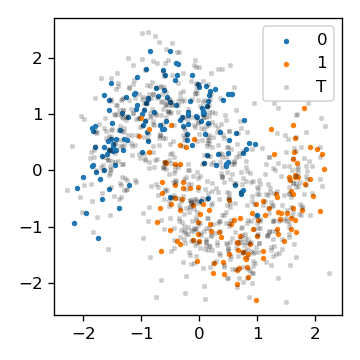

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from funciones import create_data, KNN

fig, ax = plt.subplots(figsize=(3, 3), tight_layout=True)
E, T = create_data(N=1000)
x, y = E # Use E para realizar validación cruzada
for c in np.unique(y):
    mask = y == c
    ax.scatter(x[mask, 0], x[mask, 1], label=c, s=5)
z, w = T # Use las etiquetas w para evaluar sus resultados finales
ax.scatter(z[:, 0], z[:, 1], c='k', s=5, marker='x',  alpha=0.2, label='T')
ax.legend();

```python
%time mi_resultado = mi_funcion(mis_argumentos)

%timeit -r10 -n5 mi_funcion(mis_argumentos)

#retortnar y guardar objeto '-o'
xd = %timeit -r10 -n5 -o mi_funcion(mis_argumentos)

#ademas guardar lo que retorna la funcion a evaluar
xd = %timeit -r10 -n5 -o xdd = mi_funcion(mis_argumentos)

#mide la cantidad de llamadas y el tiempo de cada función
%prun mi_funcion()

#ordenado segun el tiempo acumulado
%prun -s cumtime mi_funcion()

#line profiler
#conda install line_profiler
%load_ext line_profiler

%lprun -f mi_método mi_rutina

#verificar resultados
np.allclose(result1, result2)
```


In [3]:
print(f"x: {x.shape}, y: {y.shape}, z: {z.shape}")
print(250*750)
print(x.dtype)

x: (250, 2), y: (250,), z: (750, 2)
187500
float64


### KNN de sklearn

Para obtener un objetivo a alcanzar para nuestra versión optimizada de KNN, podemos utilizar `KNeighborsClassifier` de `sklearn.neighbors` y medir su tiempo de ejecución con la misma entrada.
En primer lugar instanciamos el clasificador con las mismas características que la función `KNN inocente` que fue proporcionada:

In [2]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5, weights='distance',
                             algorithm='brute', p=2, n_jobs=1)

Medimos el tiempo de ajuste y predicción, para luego almacenarlo en la variable `totalTimeSklearn`

In [3]:
%%timeit -r 10 -n 10 -o 
neigh.fit(x, y)
neigh.predict(z)

18.8 ms ± 5.23 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


<TimeitResult : 18.8 ms ± 5.23 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)>

In [6]:
totalTimeSklearn = _

Comparamos los resultados de las predicciones para los dos algoritmos:

In [7]:
zySklearn = neigh.predict(z)
zy = KNN(x, y, z, k=5, p=2.)
display(np.allclose(zy, zySklearn))
#mask = zy - zySklearn != 0

True

Medimos el tiempo de ejecución de la implementación naive

In [8]:
totalTimeNaive = %timeit -r 10 -n 1 -o KNN(x, y, z, k=5, p=2.)

18.8 s ± 446 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


Lo que nos entrega el siguiente speed-up:

In [10]:
print(f"speedup knn naive / knn_skl:\n{totalTimeNaive.average / totalTimeSklearn.average : .3f}")

speedup knn naive / knn_skl:
 710.295


### 1- Realice un profiling completo de la función KNN usando las magias timeit, prun y lprun

**Tiempo total de la función KNN con la magia `%timeit` (previamente calculado)**

In [11]:
display(totalTimeNaive)
print(f"min : {totalTimeNaive.best:.3f}[s], max: {totalTimeNaive.worst:.3f}[s]")

<TimeitResult : 18.8 s ± 446 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>

min : 18.454[s], max: 20.062[s]


**Cantidad de llamadas y el tiempo de cada función ejecutada por `KNN` utilizando la magia `%prun`**

In [10]:
%prun -s tottime KNN(x, y, z, k=5, p=2.)

De este profiling se observa la gran cantidad de funciones que son llamadas dentro del primer ciclo for anidado, o sea, la linea 21 de `funciones.py` que se ejecuta N * M veces.


```python
dist[i, j] = np.power(np.sum(np.power(np.absolute(Z[i] - X[j]), p)), 1./p)
```

Probablemente sea esta linea el principal contribuyente al tiempo que tarda el algoritmo.

**Profiling línea a línea con `%lprun`**

In [4]:
%load_ext line_profiler

In [15]:
lineProf = %lprun -r -f KNN KNN(x, y, z, k=5, p=2.)

In [16]:
lineProf.print_stats()

Timer unit: 1e-07 s

Total time: 3.35924 s
File: C:\Users\josenoob\Desktop\INFO147\INFO147_TAREA03\funciones.py
Function: KNN at line 14

Line #      Hits         Time  Per Hit   % Time  Line Contents
    14                                           def KNN(X, Y, Z, k=5, p=2.):
    15         1       1819.0   1819.0      0.0      C = np.unique(Y)
    16         1         29.0     29.0      0.0      N, D = X.shape
    17         1         13.0     13.0      0.0      M, _ = Z.shape
    18         1       1200.0   1200.0      0.0      dist = np.zeros(shape=(M, N))
    19       751       4362.0      5.8      0.0      for i in range(M):
    20    188250    1398973.0      7.4      4.2          for j in range(N):
    21    187500   31766444.0    169.4     94.6              dist[i, j] = np.power(np.sum(np.power(np.absolute(Z[i] - X[j]), p)), 1./p)
    22         1      69782.0  69782.0      0.2      neighbours = np.argsort(dist, axis=1)[:, :k]
    23         1         73.0     73.0      0.0   

Como sospechábamos, un enorme margen del tiempo total de ejecución se debe a la línea que calcula y almacena la distancia entre cada par de datos que, junto a su respectivo `for` **acumulan cerca del 98% del total del tiempo de ejecución:**


```python
20) for j in range(N):
21)    dist[i, j] = np.power(np.sum(np.power(np.absolute(Z[i] - X[j]), p)), 1./p)
```


Principalmente la línea (21) con más del 94% del total, línea que llamó nuestra atención en el profiling previo por todas las llamadas a funciones que realiza debido a los numerosos cálculos matemáticos complejos que efectúa.

Con esto en mente, buscaremos optimizar esta problemática línea, y la función en general, con el fin de reducir el tiempo de ejecución del algoritmo. Para esto, utilizaremos **Cython** aplicando las mejoras que aprendimos en el curso como el uso de **tipos estáticos** y de **funciones nativas de C** para los cálculos matemáticos.

In [5]:
%load_ext cython

In [6]:
from Cython.Compiler import Options
Options.get_directive_defaults()['profile'] = True
Options.get_directive_defaults()['linetrace'] = True
Options.get_directive_defaults()['binding'] = True

%%cython -a --compile-args=-DCYTHON_TRACE=1 --force

In [8]:
%%cython --compile-args=-DCYTHON_TRACE=1 --force
import numpy as np
cimport cython
cimport numpy as npc

ctypedef npc.float64_t TIPO_t
TIPO = np.float64

ctypedef npc.int64_t TIPO_i
TIPI = np.int64

cdef extern from "math.h":
    TIPO_t pow(TIPO_t, TIPO_t)
    TIPO_t fabs(TIPO_t)

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def KNN_Cython(TIPO_t [:, ::1] X, TIPO_i [::1] Y, TIPO_t [:, ::1] Z, int k=5, TIPO_t p=2.):    
    
    Cn = np.unique(Y)
    cdef:
        TIPO_i [::1] C = Cn
        int nUniques = Cn.shape[0]
        Py_ssize_t N = X.shape[0]
        Py_ssize_t D = X.shape[1]
        Py_ssize_t M = Z.shape[0]
        Py_ssize_t i, j, l
        TIPO_t exponent = 1/p
        
    dist = np.zeros(shape=(M, N), dtype=TIPO)
    cdef TIPO_t [:, ::1] dist_view = dist
        
    for i in range(M):
        for j in range(N):
            for l in range(D):
                dist_view[i, j] += pow(fabs(Z[i][l] - X[j][l]), p)
            dist_view[i, j] = pow(dist_view[i, j], exponent)

    neighbros = np.asarray(np.argsort(dist_view, axis=1)[:, :k], order='C')
    Zz_Y = np.zeros(shape=(M, ), dtype=TIPO)
    crit = np.zeros(shape=(nUniques,), dtype=TIPO)

    cdef:
        TIPO_i [:, ::1] neighbours = neighbros
        TIPO_t [::1] Z_Y = Zz_Y
        TIPO_t [::1] criterion = crit
        TIPO_i neigh
        TIPO_t valmax
        
    for i in range(M):
        valmax = 0.
        for j in range(nUniques):
            criterion[j] = 0.
            for l in range(k):
                neigh = neighbours[i][l]
                if(Y[neigh] == C[j]):
                    criterion[j] += 1/(dist_view[i, neigh])
            if valmax < criterion[j]:
                Z_Y[i] = j
                valmax = criterion[j]
    return Zz_Y

In [10]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp --force

cimport cython
import numpy as np
cimport numpy as npc
from cython.parallel import prange

ctypedef npc.float64_t TIPO_t
TIPO = np.float64

ctypedef npc.int64_t TIPO_i
TIPI = np.int64

cdef extern from "math.h" nogil:
    TIPO_t pow(TIPO_t, TIPO_t)
    TIPO_t fabs(TIPO_t)

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def KNN_Cython_parallel(TIPO_t [:, ::1] X, TIPO_i [:] Y, TIPO_t [:, ::1] Z, int k=5, TIPO_t p=2.):    
    
    Cn = np.unique(Y)
    cdef:
        TIPO_i [:] C = Cn
        int nUniques = Cn.shape[0]
        Py_ssize_t N = X.shape[0]
        Py_ssize_t D = X.shape[1]
        Py_ssize_t M = Z.shape[0]
        Py_ssize_t i, j, l
        TIPO_t exponent = 1/p
        
    dist = np.zeros(shape=(M, N), dtype=TIPO)
    cdef TIPO_t [:, ::1] dist_view = dist
    with nogil:    
        for i in prange(M, num_threads=4):
            for j in range(N):
                for l in range(D):
                    dist_view[i, j] += pow(fabs(Z[i][l] - X[j][l]), p)
                dist_view[i, j] = pow(dist_view[i, j], exponent)

    neighbros = np.asarray(np.argsort(dist_view, axis=1)[:, :k], order='C')
    Zz_Y = np.zeros(shape=(M, ), dtype=TIPO)
    crit = np.zeros(shape=(nUniques,), dtype=TIPO)

    cdef:
        TIPO_i [:, ::1] neighbours = neighbros
        TIPO_t [:] Z_Y = Zz_Y
        TIPO_t [:] criterion = crit
        TIPO_i neigh
        TIPO_t valmax
        
    for i in range(M):
        valmax = 0.
        for j in range(nUniques):
            criterion[j] = 0.
            for l in range(k):
                neigh = neighbours[i][l]
                criterion[j] += (Y[neigh] == C[j])/(dist_view[i, neigh])
            if valmax < criterion[j]:
                Z_Y[i] = j
                valmax = criterion[j]
    return Zz_Y

In [11]:
neigh = KNeighborsClassifier(n_neighbors=5, weights='distance',
                             algorithm='brute', p=2, n_jobs=4)
neigh.fit(x, y)

KNeighborsClassifier(algorithm='brute', n_jobs=4, weights='distance')

In [12]:
display(np.allclose(KNN(x, y, z, k=5, p=2.), KNN_Cython_parallel(x, y, z, k=5, p=2.)))
display(np.allclose(KNN_Cython(x, y, z, k=5, p=2.), neigh.predict(z)))
display(np.allclose(KNN_Cython_parallel(x, y, z, k=5, p=2.), neigh.predict(z)))

True

True

True

In [13]:
#%timeit -r 10 -n 10 KNN(x, y, z, k=5, p=8.)
#%timeit -r 10 -n 1 KNN(x, y, z, k=5, p=2.)
%timeit -r 10 -n 10 KNN_Cython(x, y, z, k=5, p=2.)
%timeit -r 10 -n 10 KNN_Cython_parallel(x, y, z, k=5, p=2.)
%timeit -r 10 -n 10 neigh.predict(z)

51.1 ms ± 193 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)
34.1 ms ± 839 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)
33.4 ms ± 628 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


linea 25: fabs es mas rapido que alternativas con if

guardar el exponente 1/p parece ser ligeramente mas rapido pero el profiling no lo demuestra

KNN() version basica

KNN_Cython sin paralelizar

KNN_CythonB paraleliza el primer for

KNN_CythonC utiliza un array view (cdef double [:, ::1] criterion = crit) que permite usar paralelismo en el for de abajo

paralelizar el ciclo for de abajo (linea 41) no parece ofrecer mejora en el tiempo de ejecucion


In [41]:
import line_profiler
profile = line_profiler.LineProfiler(KNN_Cython)
profile.runcall(KNN_Cython, x, y, z, k=5, p=2.)
profile.print_stats()

Timer unit: 1e-07 s

Total time: 0.242909 s
File: C:\Users\josenoob\.ipython\cython\_cython_magic_3d4970019c34e4efaa21ce3298399461.pyx
Function: KNN_Cython at line 18

Line #      Hits         Time  Per Hit   % Time  Line Contents
    18                                           def KNN_Cython(TIPO_t [:, ::1] X, TIPO_i [:] Y, TIPO_t [:, ::1] Z, int k=5, TIPO_t p=2.):    
    19                                               
    20         1       1140.0   1140.0      0.0      Cn = np.unique(Y)
    21                                               cdef:
    22         1         54.0     54.0      0.0          TIPO_i [:] C = Cn
    23         1          8.0      8.0      0.0          int nUniques = Cn.shape[0]
    24         1          3.0      3.0      0.0          Py_ssize_t N = X.shape[0]
    25         1          3.0      3.0      0.0          Py_ssize_t D = X.shape[1]
    26         1          3.0      3.0      0.0          Py_ssize_t M = Z.shape[0]
    27                            

In [42]:
profileB = line_profiler.LineProfiler(KNN_CythonB)
profileB.runcall(KNN_CythonB, x, y, z, k=5, p=2.)
profileB.print_stats()

Timer unit: 1e-07 s

Total time: 0.233766 s
File: C:\Users\josenoob\.ipython\cython\_cython_magic_16f368f13bd4c96b0daad74d9e392316.pyx
Function: KNN_CythonB at line 12

Line #      Hits         Time  Per Hit   % Time  Line Contents
    12                                           def KNN_CythonB(double [:, ::1] X, long long [:] Y, double [:, ::1] Z, int k=5, double p=2.):    
    13         1       1402.0   1402.0      0.1      Cn = np.unique(Y)
    14         1         60.0     60.0      0.0      cdef long long [:] C = Cn
    15         1          9.0      9.0      0.0      cdef int nUniques = Cn.shape[0]
    16         1          3.0      3.0      0.0      cdef int N = X.shape[0]
    17         1          3.0      3.0      0.0      cdef int D = X.shape[1]
    18         1          2.0      2.0      0.0      cdef int M = Z.shape[0]
    19         1          4.0      4.0      0.0      cdef double exponent = 1./p
    20         1        252.0    252.0      0.0      dist = np.empty(shape

Grafique el speed-up de su nueva función con respecto a la implementación "inocente" original para 𝑁=[10,50,100,500,1000,5000,10000]

In [15]:
%timeit?

In [15]:
#nValues = [50, 100, 500, 1000, 5000, 10000]
nValues = [50, 100, 500]
functions = [KNN, KNN_Cython, KNN_Cython_parallel]
timeResults = [[], [], []]
for j, nVal in enumerate(nValues):
    E, T = create_data(N=nVal)
    x, y = E
    z, _ = T
    for i, fun in enumerate(functions):
        if nVal <= 1000:
            timeR = %timeit -r 5 -n 1 -o -q fun(x, y, z, k=5, p=2.)
        else:
            timeR = %timeit -r 1 -n 1 -o fun(x, y, z, k=5, p=2.)
        timeResults[i].append(timeR)

In [16]:
speedUp = []
speedUpParallel = []
for i, nval in enumerate(nValues):
    speedUp.append(timeResults[0][i].average / timeResults[1][i].average)
    speedUpParallel.append(timeResults[0][i].average / timeResults[2][i].average)

<IPython.core.display.Javascript object>


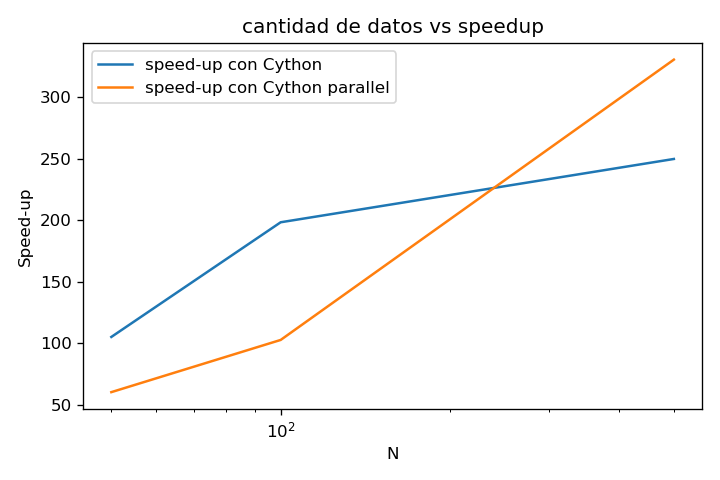

In [17]:
fig, ax = plt.subplots(tight_layout=True, figsize=(6, 4))
ax.plot(nValues, speedUp, label='speed-up con Cython')
ax.plot(nValues, speedUpParallel, label='speed-up con Cython parallel')
ax.set_title("cantidad de datos vs speedup")
ax.set_ylabel("Speed-up")
ax.set_xlabel("N")
ax.legend()
ax.set_xticks(nValues)
ax.set_xscale('log')
